<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Social Media Data Analysis - Final Project</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">Analysis</h2>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">Julia King</h4>
</div>
<br>

In [82]:
# import block

# own functions
from common_functions import confirm_execution, read_comment_df, read_video_df

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# h1
from scipy.stats import chi2_contingency

# h3 
from scipy.stats import mannwhitneyu


In [2]:
# overarching functions

def row_share(df : pd.DataFrame) -> pd.DataFrame:
    """Given a df with numeric values, converts all entries to the share of the row: cell = cell/sum(row)

    Args:
        df (pd.DataFrame): df with numeric columns only

    Returns:
        pd.DataFrame: df with the cells converted
    """
    return df.div(df.sum(axis = 1), axis = 0)

# overarching variables
phase_labels = ["before", "1st spike", "2nd spike", "after"]

# 7. Conduct statistical analysis to test the hypotheses above.

## 7.1 Videos produced before the first spike in public interest are more likely to be non-conspirative compared to those uploaded during and after the spike.

H0: Videos produced before the first spike in public interest are less or equally likely to be non-conspirative compared to those uploaded during and after the spike.

To test the hypothesis, i will need to test for statistical independence of two categorical variables: conspirative and phase. Thus, a Chi-Square test will be applied.

In [3]:
# load relevant data

video_df = read_video_df()

In [4]:
# create contingency table

h1_contingency = pd.crosstab(video_df["phase"],video_df["conspirative_auto"], margins = False)
h1_contingency

conspirative_auto,False,True
phase,,
0,182,88
1,311,880
2,184,370
3,440,488


In [5]:
h1_shares = row_share(h1_contingency)

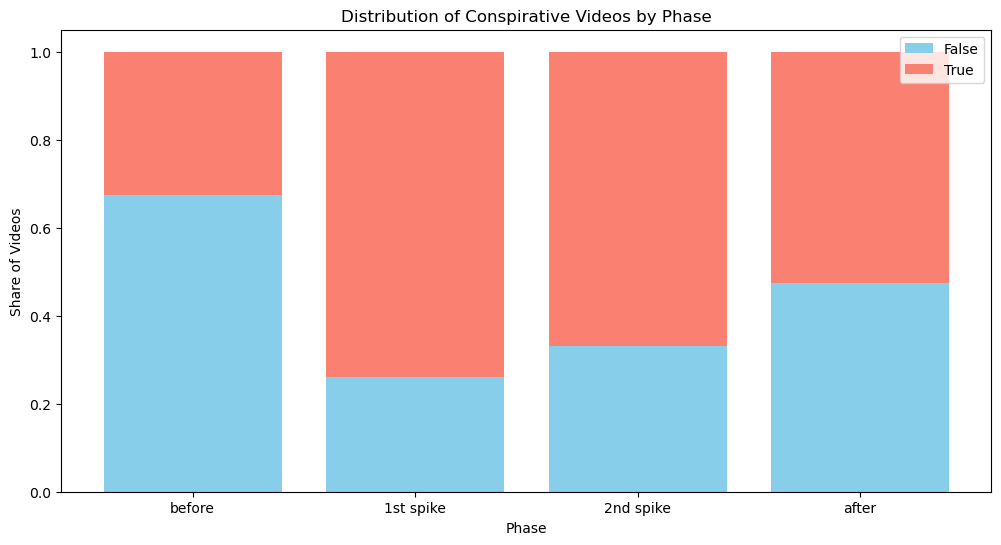

In [6]:
# plot share of conspirative videos per phase
plt.figure(figsize = (12, 6))
plt.bar(phase_labels, h1_shares[False], label = "False", color = "skyblue")
plt.bar(phase_labels, h1_shares[True], bottom = h1_shares[False], label = "True", color = "salmon")

# Labels and title
plt.xlabel("Phase")
plt.ylabel("Share of Videos")
plt.title("Distribution of Conspirative Videos by Phase")
plt.legend()

# Show plot
plt.show()

In [7]:
h1_chi2, h1_p, h1_dof, h1_expected = chi2_contingency(h1_contingency)
h1_expected = pd.DataFrame(h1_expected, index = h1_contingency.index, columns = h1_contingency.columns)

print("Chi-square statistic:", h1_chi2)
print("p-value:", h1_p)
print("Expected distributions under h0: \n", h1_expected)

Chi-square statistic: 210.93240934076437
p-value: 1.8309036247353845e-45
Expected distributions under h0: 
 conspirative_auto       False       True 
phase                                    
0                  102.477064  167.522936
1                  452.037717  738.962283
2                  210.267754  343.732246
3                  352.217465  575.782535


We can already observe that it is extremely unlikely that all 4 phases belong to the same distribution. 

In [8]:
# print percent deviations from expected when assuming independence

h1_shares - row_share(h1_expected)

conspirative_auto,False,True
phase,,
0,0.294529,-0.294529
1,-0.118420,0.118420
2,-0.047415,0.047415
3,0.094593,-0.094593


Once again, clear deviations between the phases are obvious. Most importantly, phase 0 (before the first spike) has significantly less conspirative videos than the other phases, further strengthening the hypothesis.

In [9]:
# finally, re-compute chi square with phase 1, 2, 3 grouped
h1_group_cont = pd.DataFrame({colname : [h1_contingency.iloc[0][colname], h1_contingency.iloc[1:][colname].sum()] for colname in h1_contingency.columns})
h1_group_cont

,False,True
0,182,88
1,935,1738


In [10]:
h1_group_chi2, h1_group_p, h1_group_dof, h1_group_expected = chi2_contingency(h1_group_cont)
h1_group_expected = pd.DataFrame(h1_group_expected, index = h1_group_cont.index, columns = h1_group_cont.columns)

print("Chi-square statistic:", h1_group_chi2)
print("p-value:", h1_group_p)
print("Expected distributions under h0: \n", h1_group_expected)

Chi-square statistic: 108.1335440941017
p-value: 2.512648199037469e-25
Expected distributions under h0: 
          False        True 
0   102.477064   167.522936
1  1014.522936  1658.477064


We once again observe a significant difference between "before the spike" and "during / after the spikes". Additionally, the difference is in line with our hypothesis: The share of conspirative videos in phases 1-3 is higher than expected under statistical independence and lower than expected for phase 0. Based on the results of this analysis, we can confidently reject the null hypothesis.

## 7.2. Comments under conspirative videos express higher levels of negative sentiment compared to comments under non-conspirative videos.

H0: Comments under conspirative videos express lower or the same levels of negative sentiment compared to comments under non-conspirative videos.

In [11]:
# load relevant data
video_df = read_video_df()
comment_df = read_comment_df()

In [12]:
# create merged df with conspirative label and mood

h2_df = pd.merge(comment_df, video_df["conspirative_auto"], left_on = "video_id", right_index = True)

h2_df.sample(3) # using sample to show different video ids

,phase,week_start,video_id,text,label_leia,conspirative_auto
comment_id,,,,,,
UgxRfrUOazR3kijrEhh4AaABAg,3,2024-02-18,uTiVUyrM3Co,"Hmmm, funny, I just went and googled what you ...",Anger,True
Ugxia4V0cNC9LI7eyRV4AaABAg,1,2022-12-04,ZuPmvRAFzsc,"Welcome to The New World Order, You Will Own N...",Fear,True
UgxWeBukRn3aJPP3X1l4AaABAg,1,2023-01-22,Ovwt89_3cE4,I swear these morons just keep pushing and pus...,Anger,True


In [13]:
h2_contingency = pd.crosstab(h2_df["conspirative_auto"], h2_df["label_leia"], margins = False)
h2_contingency

label_leia,Affection,Anger,Fear,Happiness,Sadness
conspirative_auto,,,,,
False,6330,23998,7754,6788,3691
True,20916,91396,19048,15689,8483


In [14]:
h2_shares = row_share(h2_contingency)
h2_shares = h2_shares[["Happiness", "Affection", "Sadness", "Anger", "Fear"]]
h2_shares

label_leia,Happiness,Affection,Sadness,Anger,Fear
conspirative_auto,,,,,
False,0.139783,0.130352,0.076007,0.494183,0.159675
True,0.100873,0.134480,0.054542,0.587635,0.122470


In [15]:
# add grouped version

h2_group_shares = pd.DataFrame({
    'Positive': h2_shares[['Affection', 'Happiness']].sum(axis=1),
    'Negative': h2_shares[['Anger', 'Fear', 'Sadness']].sum(axis=1)
}, index = h2_shares.index)

h2_group_shares

,Positive,Negative
conspirative_auto,,
False,0.270134,0.729866
True,0.235353,0.764647


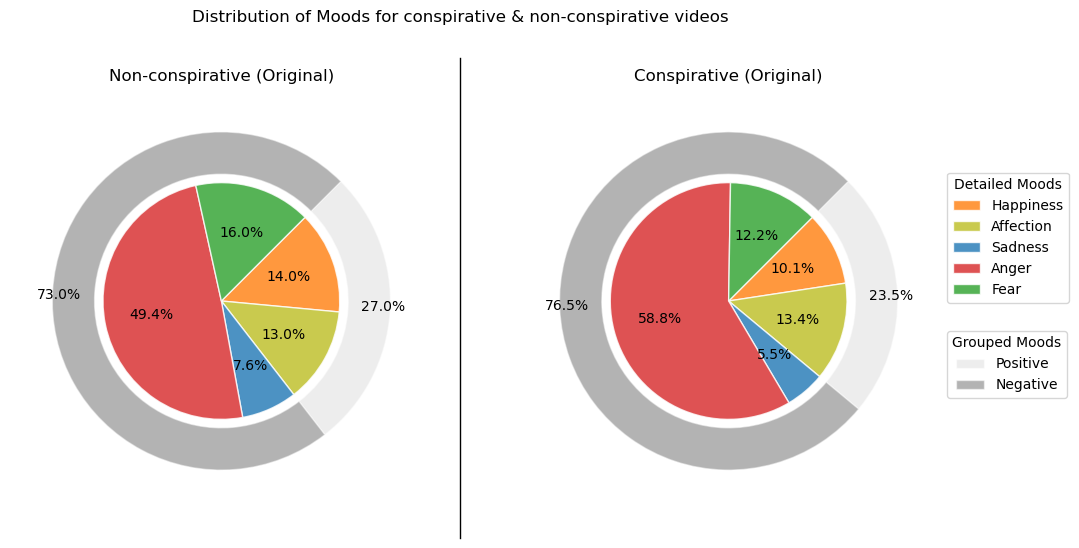

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

mood_colors = {"Affection" : "#bcbd22", 
               "Anger" : "#d62728", 
               "Fear" : "#2ca02c", 
               "Happiness" : "#ff7f0e", 
               "Sadness" : "#1f77b4", 
               "Positive" : "gainsboro", 
               "Negative" : "dimgrey"}

# Flatten the axes array for easier indexing
ax = ax.flatten()

# Plot the original sentiment shares
for i, row in enumerate(h2_shares.index):
    # Original sentiment pie
    wedges_inner, texts_inner, autotexts_inner = ax[i].pie(h2_shares.loc[row], 
                          colors=[mood_colors[label] for label in h2_shares.columns], 
                          autopct="%1.1f%%", 
                          startangle=45, 
                          counterclock=False,
                          radius=0.7, 
                          wedgeprops=dict(edgecolor='w', linewidth=1, alpha=0.8))
    
    # Overlay grouped sentiment pie
    wedges_outer, texts_outer, autotexts_outer = ax[i].pie(h2_group_shares.loc[row], 
              colors=[mood_colors[label] for label in h2_group_shares.columns], 
              autopct="%1.1f%%", 
              startangle=45, 
              counterclock=False,
              radius=1,
              wedgeprops=dict(width=0.25, edgecolor='w', linewidth=1, alpha=0.5))
    
    # Move the outer layer text further away from the center
    for text in autotexts_outer:
        text.set_verticalalignment('center')
        text.set_horizontalalignment('center')
        # Adjust text position further away from center
        text.set_x(text.get_position()[0] * 1.6)  # Increase or decrease the multiplier to move text further
    
    # Set title
    ax[i].set_title(f"{'Conspirative' if row else 'Non-conspirative'} (Original)")

# Add a single legend on the first subplot
ax[1].legend(wedges_inner, h2_shares.columns, title="Detailed Moods", loc="center left", bbox_to_anchor=(1, 0.15, 0.5, 1))
ax[0].legend(wedges_outer, h2_group_shares.columns, title="Grouped Moods", loc="center left", bbox_to_anchor=(2.2, -0.15, 0.5, 1))

# Add separation line
line = plt.Line2D((.5, .5), (.1, .9), color="k", linewidth=1)
fig.add_artist(line)

# Adjust layout
plt.suptitle("Distribution of Moods for conspirative & non-conspirative videos")

# Show plot
plt.show()


We can observe significant differences in the distribution of detailed moods. This is especially pronounced with Anger, increasing from 49% to 59%. However, the differences in grouped moods are much less pronounced, only differing by ~3%.

We first conduct some analysis on the detailed moods.

In [17]:
# chi squared test

h2_chi2, h2_p, h2_dof, h2_expected = chi2_contingency(h2_contingency)
h2_expected = pd.DataFrame(h2_expected, index = h2_contingency.index, columns = h2_contingency.columns)

print("Chi-square statistic:", h2_chi2)
print("p-value:", h2_p)
print("Expected distributions under h0: \n", h2_expected)

Chi-square statistic: 1761.0159619007134
p-value: 0.0
Expected distributions under h0: 
 label_leia            Affection         Anger         Fear     Happiness  \
conspirative_auto                                                          
False               6482.794638  27456.346048   6377.15121   5348.079537   
True               20763.205362  87937.653952  20424.84879  17128.920463   

label_leia             Sadness  
conspirative_auto               
False              2896.628566  
True               9277.371434  


In [18]:
h2_shares - row_share(h2_expected)

label_leia,Affection,Anger,Fear,Happiness,Sadness
conspirative_auto,,,,,
False,-0.003146,-0.071217,0.028353,0.029652,0.016358
True,0.000982,0.022236,-0.008853,-0.009258,-0.005107


Text(45.722222222222214, 0.5, 'Is video conspirative?')

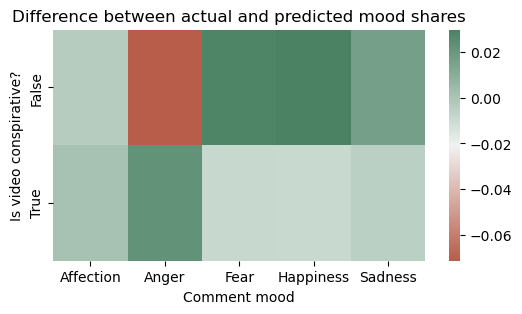

In [19]:
plt.figure(figsize = (6, 3))
sns.heatmap(h2_shares - row_share(h2_expected), cmap = sns.diverging_palette(20, 145, s=60, as_cmap=True))
plt.title("Difference between actual and predicted mood shares")
plt.xlabel("Comment mood")
plt.ylabel("Is video conspirative?")

The plot reveals an important insight: Conspirative videos are significantly more likely illicit anger than non-conspirative videos. 
We now conduct a test for the hypothesis regarding grouped variables.

In [21]:
h2_group_cont = pd.DataFrame({
    'Positive': h2_contingency[['Affection', 'Happiness']].sum(axis=1),
    'Negative': h2_contingency[['Anger', 'Fear', 'Sadness']].sum(axis=1)
}, index = h2_contingency.index)

h2_group_cont

,Positive,Negative
conspirative_auto,,
False,13118,35443
True,36605,118927


In [22]:
# chi squared test

h2_group_chi2, h2_group_p, h2_group_dof, h2_group_expected = chi2_contingency(h2_group_cont)
h2_group_expected = pd.DataFrame(h2_group_expected, index = h2_group_cont.index, columns = h2_group_cont.columns)

print("Chi-square statistic:", h2_group_chi2)
print("p-value:", h2_group_p)
print("Expected distributions under h0: \n", h2_group_expected)

Chi-square statistic: 242.7511249393658
p-value: 9.882149642024045e-55
Expected distributions under h0: 
                        Positive       Negative
conspirative_auto                             
False              11830.874175   36730.125825
True               37892.125825  117639.874175


In [24]:
h2_group_shares - row_share(h2_group_expected)

,Positive,Negative
conspirative_auto,,
False,0.026505,-0.026505
True,-0.008276,0.008276


As seen before, the magnitude of the differences between positive and negative sentiment is much smaller than the differences in individual sentiments. Thus, while we do find significant evidence for a difference in grouped moods, the small magnitude makes it hard to draw interesting conclusions.

## 7.3. The engagement metrics (e.g., likes, comments, shares per view) of conspirative videos differ significantly from those of non-conspirative videos, with conspirative videos having higher engagement rates per view.

H0: There is no significant difference in engagement rates (likes, comments, shares per view) between conspirative and non-conspirative videos.

In [47]:
# load relevant data
video_df = read_video_df()

In [57]:
# filter for videos with views and create relevant variables
# filtering is done cause videos with 0 views will not have engagements

engagement_df = video_df[video_df["views"] > 0].copy()

# engagement
engagement_df["likes_per_view"] = engagement_df["likes"] / engagement_df["views"]
engagement_df["comments_per_view"] = engagement_df["comments"] / engagement_df["views"]

# also make logged versions
engagement_df["log_likes_per_view"] = np.log(engagement_df["likes_per_view"] + 0.001) # small constant added to avoid inf
engagement_df["log_comments_per_view"] = np.log(engagement_df["comments_per_view"] + 0.001)


# the youtube api returned some obviously false numbers (a few items with more likes than views). This persists even after reruns. Thus, they are discarded.
engagement_df = engagement_df[(engagement_df["likes_per_view"] <= 1) & (engagement_df["comments_per_view"] <= 1)]

,phase,week_start,title,description,views,clean,likes,comments,conspirative_auto,conspirative_manual,likes_per_view,comments_per_view,log_likes_per_view,log_comments_per_view
video_id,,,,,,,,,,,,,,
Gg38BtcNioY,0,2022-03-20,The Office of Community Development! 15-Minute...,🛣️Watch the next episode: https://youtu.be/Vd2...,991,office community development 15 minute city 10...,100.0,64,False,<NA>,0.100908,0.064581,-2.283683,-2.724466
Ne6nrlB_3os,0,2022-03-20,URBTalk: 20 Minute Neighbourhood,URBTalk presentation on the 20 minute neighbou...,166,urbtalk 20 minute neighbourhood urbtalk presen...,1.0,0,False,<NA>,0.006024,0.000000,-4.958409,-6.907755
2mezuB5BwnA,0,2022-03-20,Expo 2020 Dubai Will Reopen As A 15-Minute Cit...,.,114,expo 2020 dubai reopen 15 minute city 10 pavil...,0.0,0,True,<NA>,0.000000,0.000000,-6.907755,-6.907755
drWGeJxfwmQ,0,2022-03-27,CRID Webinar Series #26 - FUTURE CITIES - CITI...,This session from the CRID Webinar Series will...,12,crid webinar series 26 future city city future...,0.0,0,False,<NA>,0.000000,0.000000,-6.907755,-6.907755
vqGmvOqVS0Y,0,2022-04-03,15-Minute Easy Qigong Exercise | Fitness & Hea...,Qigong master Lawrence Tse shares an easy exer...,2787,15 minute easy qigong exercise fitness health ...,231.0,2,False,<NA>,0.082885,0.000718,-2.478311,-6.366817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mq1C3LPKAVc,3,2024-06-23,"Canadian Federal 15 Minute City Initiative, pr...","Canadian Federal 15 Minute City Initiative, pr...",5,canadian federal 15 minute city initiative pre...,0.0,0,True,True,0.000000,0.000000,-6.907755,-6.907755
PNoG4ycLiB0,3,2024-06-23,Utopian Present: China's Modern Gulag,"20,000 people live/survive, in this building i...",6,utopian present china modern gulag 20 000 peop...,0.0,0,False,<NA>,0.000000,0.000000,-6.907755,-6.907755
RN8x1drBzyg,3,2024-06-23,"Paris Building an Olympic ""15 Minute City""?",Is the Paris Olympic village really just a mod...,5,paris building olympic 15 minute city paris ol...,0.0,0,True,<NA>,0.000000,0.000000,-6.907755,-6.907755


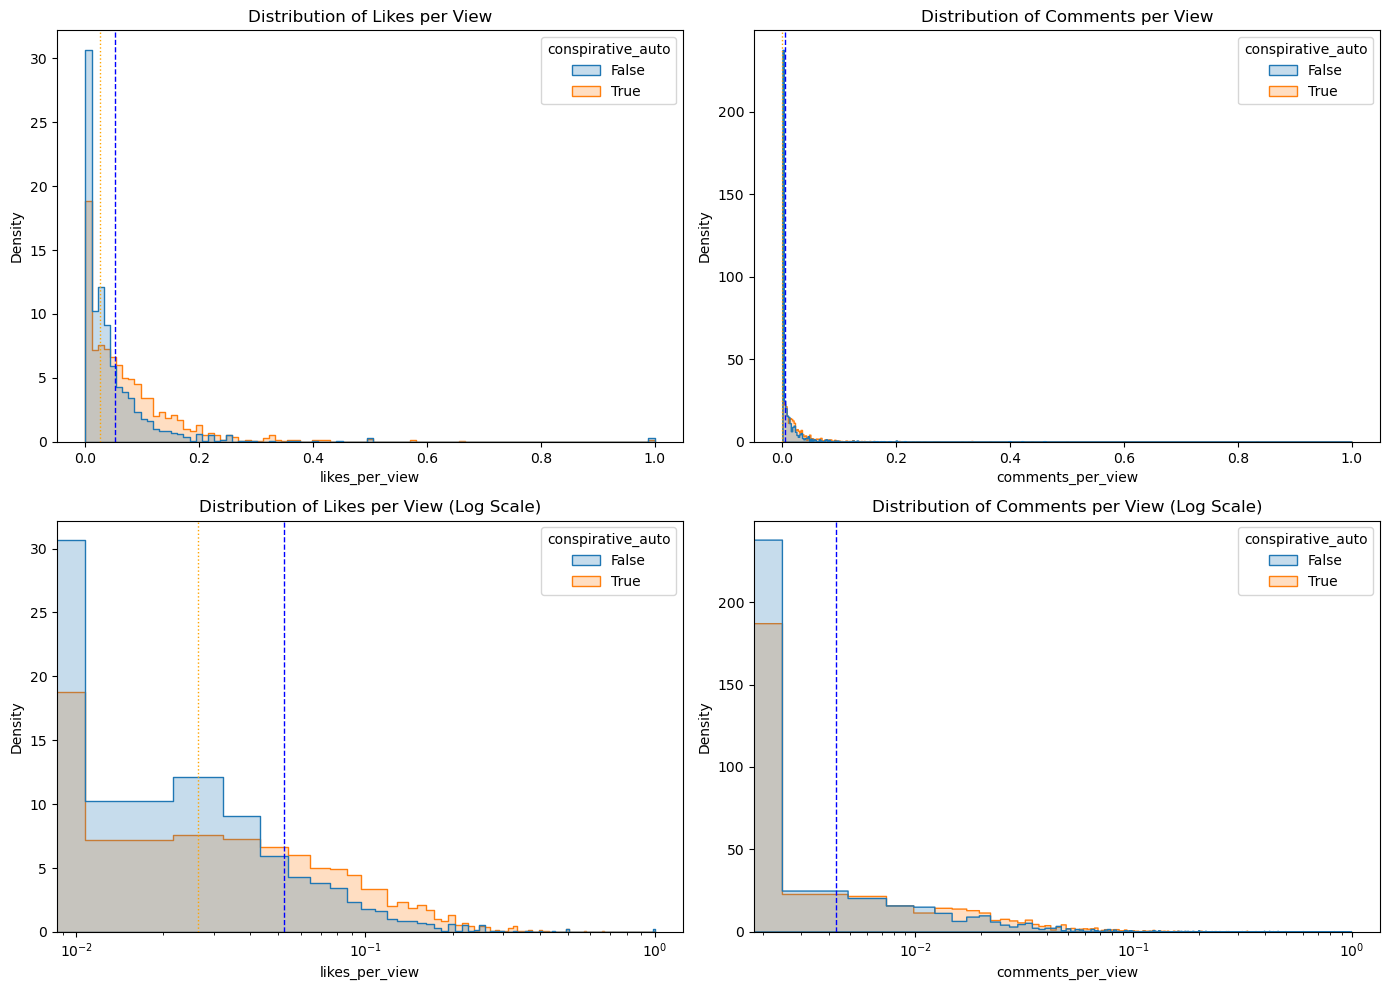

In [81]:
# plot distributions
fig, axes = plt.subplots(2, 2, figsize = (14, 10))

# likes 
sns.histplot(data = engagement_df, x = "likes_per_view", hue = "conspirative_auto", element = "step", stat = "density", common_norm = False, ax = axes[0, 0])
axes[0, 0].set_title("Distribution of Likes per View")
axes[0, 0].axvline(engagement_df[engagement_df["conspirative_auto"] ==  True]["likes_per_view"].median(), color = "blue", linestyle = "--", linewidth = 1)
axes[0, 0].axvline(engagement_df[engagement_df["conspirative_auto"] ==  False]["likes_per_view"].median(), color = "orange", linestyle = ":", linewidth = 1)

# comments
sns.histplot(data = engagement_df, x = "comments_per_view", hue = "conspirative_auto", element = "step", stat = "density", common_norm = False, ax = axes[0, 1])
axes[0, 1].axvline(engagement_df[engagement_df["conspirative_auto"] ==  True]["comments_per_view"].median(), color = "blue", linestyle = "--", linewidth = 1)
axes[0, 1].axvline(engagement_df[engagement_df["conspirative_auto"] ==  False]["comments_per_view"].median(), color = "orange", linestyle = ":", linewidth = 1)
axes[0, 1].set_title("Distribution of Comments per View")

# same with log
sns.histplot(data = engagement_df, x = "likes_per_view", hue = "conspirative_auto", element = "step", stat = "density", common_norm = False, ax = axes[1, 0])
axes[1, 0].set_title("Distribution of Likes per View (Log Scale)")
axes[1, 0].set_xscale("log")
axes[1, 0].axvline(engagement_df[engagement_df["conspirative_auto"] ==  True]["likes_per_view"].median(), color = "blue", linestyle = "--", linewidth = 1)
axes[1, 0].axvline(engagement_df[engagement_df["conspirative_auto"] ==  False]["likes_per_view"].median(), color = "orange", linestyle = ":", linewidth = 1)

sns.histplot(data = engagement_df, x = "comments_per_view", hue = "conspirative_auto", element = "step", stat = "density", common_norm = False, ax = axes[1, 1])
axes[1, 1].set_title("Distribution of Comments per View (Log Scale)")
axes[1, 1].set_xscale("log")
axes[1, 1].axvline(engagement_df[engagement_df["conspirative_auto"] ==  True]["comments_per_view"].median(), color = "blue", linestyle = "--", linewidth = 1)
axes[1, 1].axvline(engagement_df[engagement_df["conspirative_auto"] ==  False]["comments_per_view"].median(), color = "orange", linestyle = ":", linewidth = 1)

# Adjust layout
plt.tight_layout()
plt.show()

As expected, the distributions are very non-normal, even when logged. Thus, a non-parametric model is chosen instead of a t-test. This test compares the medians of the two distributions, which is adequate here, as we have such very non-normal distributions.

However, in the logged plots, we can the opposite trend than expected: The median comment and like counts of conspirative videos are lower than those of non-conspirative ones, with the mean conspirative video even receiving 0 comments! 

We will test if these differences are significant.

In [83]:
# testing likes
likes_conspirative = engagement_df[engagement_df["conspirative_auto"] == 1]["likes_per_view"]
likes_non_conspirative = engagement_df[engagement_df["conspirative_auto"] == 0]["likes_per_view"]
u_stat_likes, p_value_likes = mannwhitneyu(likes_conspirative, likes_non_conspirative)

# testing comments
comments_conspirative = engagement_df[engagement_df["conspirative_auto"] == 1]["comments_per_view"]
comments_non_conspirative = engagement_df[engagement_df["conspirative_auto"] == 0]["comments_per_view"]
u_stat_comments, p_value_comments = mannwhitneyu(comments_conspirative, comments_non_conspirative)

print(f"Mann-Whitney U Test for Likes per View: U-statistic = {u_stat_likes}, p-value = {p_value_likes}")
print(f"Mann-Whitney U Test for Comments per View: U-statistic = {u_stat_comments}, p-value = {p_value_comments}")

Mann-Whitney U Test for Likes per View: U-statistic = 1169852.5, p-value = 1.4971191681948755e-33
Mann-Whitney U Test for Comments per View: U-statistic = 1064695.5, p-value = 2.5576648406498495e-13


The differences appear significant.

For further discussion of the results and limitations, see the report.